# CIFAR-100 Classification with a Softmax Head
We train a convolutional encoder with a softmax classifier on CIFAR-100 and visualise the learned embedding space.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
pin_memory = torch.cuda.is_available()

train_tfm = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root='./data', train=True, transform=train_tfm, download=True)
test_ds  = datasets.CIFAR100(root='./data', train=False, transform=test_tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=pin_memory)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=4, pin_memory=pin_memory)
len(train_ds), len(test_ds)


(50000, 10000)

### Model: encoder + softmax head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class SoftmaxHead(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.linear = nn.Linear(D, C)

    def forward(self, z):
        return self.linear(z)

class DeepClassifier(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = SoftmaxHead(D, C)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepClassifier(C=100, D=99).to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)

    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


[01] train loss=3.7068 acc=0.1243 | test acc=0.1619
[02] train loss=2.9993 acc=0.2365 | test acc=0.2546
[03] train loss=2.5830 acc=0.3212 | test acc=0.2566
[04] train loss=2.2904 acc=0.3879 | test acc=0.3672
[05] train loss=2.0773 acc=0.4327 | test acc=0.3969
[06] train loss=1.9163 acc=0.4716 | test acc=0.3943
[07] train loss=1.7746 acc=0.5050 | test acc=0.4514
[08] train loss=1.6695 acc=0.5312 | test acc=0.4896
[09] train loss=1.5781 acc=0.5540 | test acc=0.4461
[10] train loss=1.4869 acc=0.5750 | test acc=0.4753
[11] train loss=1.4160 acc=0.5945 | test acc=0.5005
[12] train loss=1.3422 acc=0.6138 | test acc=0.5325
[13] train loss=1.2839 acc=0.6266 | test acc=0.5417
[14] train loss=1.2370 acc=0.6392 | test acc=0.5574
[15] train loss=1.1829 acc=0.6521 | test acc=0.5475
[16] train loss=1.1317 acc=0.6649 | test acc=0.5560
[17] train loss=1.0943 acc=0.6780 | test acc=0.5694
[18] train loss=1.0439 acc=0.6902 | test acc=0.5713
[19] train loss=1.0066 acc=0.7000 | test acc=0.5754
[20] train l

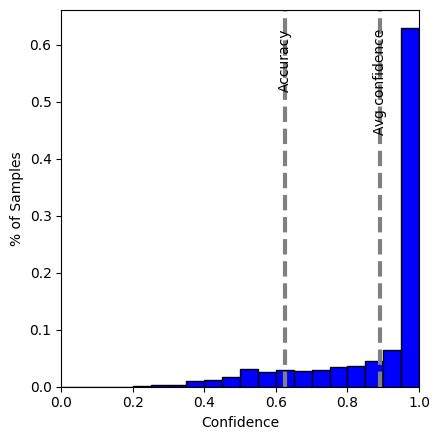

In [6]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
conf_list = []
pred_list = []
label_list = []
with torch.no_grad():
    for x, y in test_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        conf, pred = probs.max(1)
        conf_list.append(conf.cpu())
        pred_list.append(pred.cpu())
        label_list.append(y.cpu())

conf = torch.cat(conf_list).numpy()
pred = torch.cat(pred_list)
labels = torch.cat(label_list)
acc = (pred == labels).float().mean().item()
avg_conf = conf.mean().item()

bins = np.linspace(0.0, 1.0, 21)
weights = np.ones_like(conf) / conf.size

plt.figure(figsize=(4.5, 4.5))
plt.hist(conf, bins=bins, weights=weights, color='blue', edgecolor='black')
plt.axvline(avg_conf, color='gray', linestyle='--', linewidth=3)
plt.axvline(acc, color='gray', linestyle='--', linewidth=3)
plt.text(avg_conf, 0.95 * plt.gca().get_ylim()[1], 'Avg confidence',
         rotation=90, va='top', ha='center')
plt.text(acc, 0.95 * plt.gca().get_ylim()[1], 'Accuracy',
         rotation=90, va='top', ha='center')
plt.xlabel('Confidence')
plt.ylabel('% of Samples')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('plots/cifar100_softmax_confidence_hist.png', dpi=600)


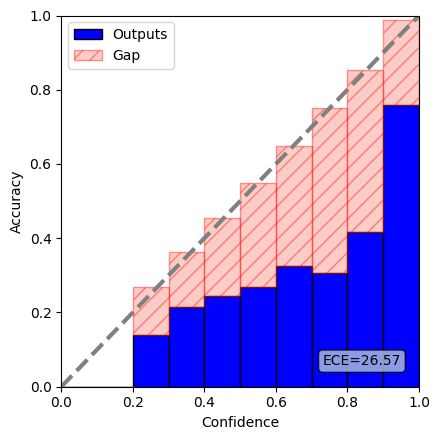

In [7]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
conf_list = []
pred_list = []
label_list = []
with torch.no_grad():
    for x, y in test_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        conf, pred = probs.max(1)
        conf_list.append(conf.cpu())
        pred_list.append(pred.cpu())
        label_list.append(y.cpu())

conf = torch.cat(conf_list).numpy()
pred = torch.cat(pred_list).numpy()
labels = torch.cat(label_list).numpy()
correct = (pred == labels).astype(np.float32)

n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_ids = np.digitize(conf, bins[1:-1], right=True)

bin_acc = np.zeros(n_bins, dtype=np.float32)
bin_conf = np.zeros(n_bins, dtype=np.float32)
bin_frac = np.zeros(n_bins, dtype=np.float32)

for b in range(n_bins):
    mask = bin_ids == b
    if mask.any():
        bin_acc[b] = correct[mask].mean()
        bin_conf[b] = conf[mask].mean()
        bin_frac[b] = mask.mean()

ece = np.sum(np.abs(bin_acc - bin_conf) * bin_frac)

bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

plt.figure(figsize=(4.5, 4.5))
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=3)
plt.bar(bin_centers, bin_acc, width=bin_width, color='blue', edgecolor='black', label='Outputs')
gap = bin_conf - bin_acc
plt.bar(bin_centers, gap, bottom=bin_acc, width=bin_width, color='salmon', edgecolor='red',
        alpha=0.4, hatch='//', label='Gap')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.text(0.95, 0.05, f'ECE={ece*100:.2f}', ha='right', va='bottom',
         bbox=dict(boxstyle='round', facecolor='lightsteelblue', alpha=0.8))
plt.tight_layout()
plt.savefig('plots/cifar100_softmax_reliability_diagram.png', dpi=600)
